# Training Deep Neural Networks on a GPU

In the previous notebook, we trained a logistic regression model to identify handwritten digits from the MNIST dataset with an accuracy of around 86%.

![](https://cdn-images-1.medium.com/max/1600/1*q2nyeRU8uvjPeKpo_lMXgQ.jpeg)

Howerver, we also noticed that it's quite difficult to improve the accuracy beyond 87%, due to the limited power of the model. In this post, we'll try to improve upon it using a feedforward neural network.

## Preparing the Data

The data preparation is identical to the previous tutorial. We begin by importing the required modules & classes.

In [1]:
import torch
import numpy as np
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

We download the data and create a PyTorch dataset using the `MNIST` class from `torchvision.datasets`.

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [3]:
img, label = dataset[0]
img.shape, label

(torch.Size([1, 28, 28]), 5)

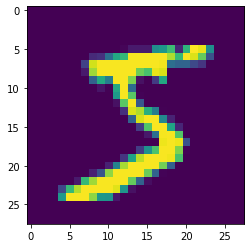

In [4]:
import matplotlib.pyplot as plt
# somehow it works even without matplotlib inline
%matplotlib inline
plt.imshow(img[0])

In [5]:
img[0,10:15,10:15]

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])

Next, we define and use a function `split_indices` to pick a random 20% fraction of the images for the validation set.

In [6]:
def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [7]:
train_indices, val_indices = split_indices(len(dataset), val_pct=0.2)

print(len(train_indices), len(val_indices))
print('Sample val indices:', val_indices[:20])

48000 12000
Sample val indices: [37826 57374 14981 41594 21561 25680 40224   288 51343 48398 19178 45271
 50954  6905 11080 42655  8193 39267 30099 45391]


We can now create PyTorch data loaders for each of the subsets using a `SubsetRandomSampler`, which samples elements randomly from a give list of indices, while creating batches of data.

In [8]:
batch_size=100

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, 
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
valid_sampler = SubsetRandomSampler(val_indices)
valid_dl = DataLoader(dataset,
                     batch_size,
                     sampler=valid_sampler)

## Model

To improve upon logistic regression, we'll create a nerual network with one hidden layer. Here's what this means: 

- Instead of using a single `nn.Layer` object to transform a batch of inputs (pixel intensities) into a batch of outputs (class probabilites), we'll use two `nn.Linear` objects. Each of these is called a layer in the network.

- The first layer (also knows as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape `batch_size x hidden_size`, where `hidden_size` is a preconfigured parameter (e.g. 32 or 64).

- The intermediate outputs are then passed into a non-linear activation function, which operates on individual elements of the output matrix.

- The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer), which transforms it into a matrix of size `batch_size` x 10, identical to the output of the logistic regression model.

Introducing a hiddenlayer and an activation function allows the model to learn more complex, multi-layered nonlinear relationships between the inputs and the targets. Here's what it looks like visually:

![](https://i.imgur.com/vDOGEkG.png)

The activation function we'll use here is called a *Rectified Linear Unit* or *ReLU*, and it has a really simple formula: `relu(x) = max(0,x)` i.e. if an element is negative, we replace it by 0, otherwhise we leave it unchanged.

To define the model, we extend the `nn.Module` class, just as we did with logistic regression.

In [9]:
import torch.nn.functional as F
import torch.nn as nn

In [10]:
for xb, yb in train_dl:
    # reshape
    xb = xb.view(xb.size(0), -1)
    
    print(xb.shape)
    
    break

torch.Size([100, 784])


In [11]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the images tensors
        # resize
        # sb.size(0) takes 0th argument --> batch_size
        # -1 because python will calculate its own value for the give resolution
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activaion function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

We'll create a model that contains a hidden layer with 32 activations.

In [27]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [28]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll takethe first batch of 100 images from our dataset, and pass them into our model.

In [29]:
for images, labels in train_dl:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break
    
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.3259778022766113
outputs.shape :  torch.Size([100, 10])
Sample outputs :
 tensor([[ 0.0045,  0.0045, -0.0513,  0.1572, -0.0996,  0.0577, -0.0227, -0.0542,
          0.2412,  0.0766],
        [-0.1190, -0.0243, -0.1109,  0.2248, -0.1874,  0.0682,  0.0143,  0.0314,
          0.2166,  0.1166]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPU's to train out models within a reasonable amount of time. GPUs contain hundreds of cores that are optimized for performing expensive matrix operations on floating point numbers in a short time, which makes them ideal for training deep neural networks with many layers. You can use GPUs for free on Kaggle kernels or Google Colab, or rent GPU-powered machines on services like Google Cloud Platform, Amazon Web Services or Paperspace.

We can chack if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [30]:
torch.cuda.is_available()

False

Let's define a helper function to ensure that our code uses the GPU if available, and defaults to usind the GPU if it isn't

In [31]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else: 
        return torch.device('cpu')

In [32]:
device = get_default_device()
device

device(type='cpu')

Next, let's define a function that can move data and model to a chosen device.

In [33]:
def to_device(data,device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [34]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cpu


Finally, we define a `DeviceDataLoader` class to wrap our existing data loaders and move data to the selected device, as batches are accessed. Interestingly, we don't need to extend an existing class to create a PyRoch dataloader. All we need is an __iter__ method to retrieve batches of data, and an __len__ mathod to get the number of batches.

In [35]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
            
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

We can now wrap our data loaders using `DeviceDataLoaders`

In [45]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

NameError: name 'train_loader' is not defined

Tensors that have been moved to the GPU's RAM have a `device` property which includes the word `cuda`. Let's verify this by looking at a batch of data from `valid_dl`. 

In [37]:
for xb, yb in valid_dl:
    print('xb.device:', xb.device)
    print('yb:', yb)

xb.device: cpu
yb: tensor([5, 3, 4, 2, 4, 6, 4, 4, 6, 1, 3, 5, 8, 2, 3, 9, 0, 0, 9, 0, 4, 6, 9, 2,
        3, 6, 7, 7, 4, 6, 3, 6, 8, 0, 7, 8, 8, 3, 0, 7, 4, 7, 2, 1, 1, 2, 7, 1,
        2, 3, 4, 6, 5, 2, 8, 3, 9, 9, 9, 4, 2, 2, 6, 1, 1, 6, 0, 9, 3, 7, 1, 8,
        3, 7, 4, 4, 0, 5, 6, 1, 6, 8, 0, 2, 6, 4, 3, 5, 6, 1, 4, 4, 2, 8, 9, 6,
        6, 6, 5, 2])
xb.device: cpu
yb: tensor([2, 2, 2, 6, 1, 2, 5, 3, 0, 6, 4, 4, 9, 4, 6, 8, 6, 8, 4, 8, 4, 3, 7, 1,
        6, 9, 6, 5, 8, 1, 3, 9, 6, 7, 7, 1, 8, 9, 3, 2, 6, 5, 4, 5, 4, 3, 2, 1,
        0, 3, 5, 2, 8, 4, 9, 7, 1, 3, 0, 3, 5, 2, 2, 7, 1, 6, 9, 8, 8, 0, 1, 8,
        6, 2, 0, 3, 5, 5, 0, 3, 1, 2, 3, 6, 0, 3, 1, 1, 3, 9, 0, 1, 5, 9, 6, 0,
        9, 8, 5, 3])
xb.device: cpu
yb: tensor([5, 0, 8, 9, 1, 1, 1, 0, 1, 1, 8, 0, 6, 9, 6, 2, 2, 6, 0, 9, 1, 1, 8, 4,
        8, 5, 7, 9, 9, 7, 4, 1, 5, 1, 4, 5, 7, 1, 0, 7, 1, 7, 3, 1, 0, 1, 0, 3,
        5, 6, 3, 3, 4, 9, 9, 8, 5, 4, 6, 6, 3, 0, 8, 4, 0, 1, 6, 5, 3, 3, 0, 9,
        9, 2, 6, 1, 3

xb.device: cpu
yb: tensor([5, 3, 2, 0, 9, 3, 8, 9, 7, 8, 2, 0, 1, 7, 5, 0, 1, 5, 8, 1, 3, 3, 3, 0,
        4, 1, 1, 0, 8, 8, 8, 4, 1, 3, 6, 3, 7, 2, 5, 0, 1, 2, 0, 3, 6, 7, 4, 0,
        8, 5, 1, 6, 3, 1, 0, 9, 4, 1, 7, 4, 9, 7, 8, 9, 1, 6, 2, 1, 2, 9, 8, 5,
        7, 0, 3, 5, 1, 3, 8, 1, 4, 6, 6, 7, 9, 8, 5, 4, 6, 4, 0, 4, 0, 5, 7, 4,
        4, 1, 6, 5])
xb.device: cpu
yb: tensor([2, 0, 0, 8, 9, 8, 5, 7, 2, 0, 1, 8, 7, 1, 2, 2, 8, 7, 3, 9, 7, 8, 5, 4,
        1, 9, 3, 9, 1, 1, 8, 1, 1, 3, 3, 2, 7, 1, 2, 8, 7, 9, 0, 6, 2, 6, 2, 6,
        5, 5, 7, 9, 7, 2, 0, 0, 8, 2, 9, 9, 7, 8, 1, 7, 0, 9, 3, 7, 7, 8, 0, 0,
        0, 6, 1, 6, 6, 9, 1, 9, 4, 2, 5, 5, 9, 1, 9, 7, 7, 0, 8, 4, 5, 0, 8, 3,
        2, 8, 5, 3])
xb.device: cpu
yb: tensor([9, 8, 6, 2, 9, 0, 1, 8, 4, 1, 5, 0, 4, 1, 0, 0, 7, 0, 2, 7, 3, 7, 7, 6,
        6, 0, 9, 8, 6, 3, 9, 5, 4, 6, 3, 1, 9, 0, 2, 4, 1, 8, 4, 0, 2, 2, 6, 5,
        8, 8, 3, 9, 4, 9, 0, 6, 0, 7, 9, 0, 7, 2, 1, 2, 6, 8, 3, 0, 3, 6, 2, 9,
        3, 9, 8, 3, 4

xb.device: cpu
yb: tensor([7, 4, 5, 0, 0, 3, 4, 0, 6, 4, 7, 6, 4, 2, 0, 2, 8, 2, 8, 9, 4, 1, 6, 9,
        7, 5, 5, 6, 2, 0, 1, 2, 7, 7, 5, 6, 0, 5, 4, 2, 0, 9, 1, 3, 7, 7, 4, 8,
        2, 1, 1, 5, 5, 0, 5, 9, 5, 0, 7, 2, 4, 5, 7, 9, 8, 1, 7, 4, 1, 3, 9, 0,
        5, 6, 4, 9, 9, 6, 9, 3, 2, 9, 1, 3, 7, 5, 7, 1, 8, 7, 4, 4, 2, 9, 1, 1,
        2, 8, 1, 5])
xb.device: cpu
yb: tensor([3, 8, 1, 5, 7, 3, 4, 6, 4, 0, 6, 8, 5, 8, 7, 0, 4, 3, 6, 5, 4, 7, 3, 7,
        9, 1, 3, 7, 3, 8, 5, 7, 2, 1, 0, 8, 0, 4, 0, 1, 5, 9, 3, 7, 3, 6, 5, 8,
        2, 1, 7, 0, 1, 0, 2, 0, 6, 0, 4, 6, 0, 7, 5, 1, 6, 5, 2, 3, 6, 3, 7, 2,
        4, 0, 2, 4, 4, 9, 4, 7, 5, 5, 8, 7, 2, 8, 3, 6, 2, 4, 1, 0, 0, 4, 4, 4,
        0, 6, 3, 6])
xb.device: cpu
yb: tensor([7, 2, 1, 9, 2, 8, 8, 4, 0, 8, 9, 9, 6, 1, 8, 7, 9, 2, 5, 3, 8, 3, 2, 0,
        1, 9, 3, 2, 7, 6, 1, 0, 9, 0, 0, 3, 1, 3, 6, 0, 5, 2, 3, 8, 3, 9, 5, 8,
        5, 9, 1, 9, 7, 2, 4, 5, 3, 0, 2, 6, 7, 0, 9, 4, 0, 8, 3, 2, 7, 5, 5, 1,
        5, 9, 8, 2, 7

xb.device: cpu
yb: tensor([0, 0, 4, 8, 4, 3, 8, 2, 5, 6, 3, 1, 8, 2, 4, 3, 2, 4, 6, 6, 2, 6, 7, 7,
        4, 5, 7, 5, 8, 3, 3, 4, 4, 2, 2, 7, 1, 3, 1, 6, 8, 2, 7, 9, 3, 4, 4, 2,
        3, 4, 1, 2, 5, 9, 8, 3, 7, 7, 6, 5, 1, 8, 6, 2, 3, 6, 5, 0, 1, 1, 3, 2,
        4, 9, 8, 8, 5, 4, 8, 5, 2, 7, 1, 5, 4, 3, 8, 3, 7, 6, 8, 2, 8, 7, 2, 9,
        0, 7, 9, 9])
xb.device: cpu
yb: tensor([9, 8, 7, 0, 3, 7, 0, 2, 3, 7, 3, 7, 5, 6, 1, 8, 1, 0, 6, 1, 4, 4, 2, 8,
        0, 7, 0, 9, 9, 8, 1, 4, 4, 1, 3, 5, 8, 6, 7, 4, 8, 9, 0, 6, 2, 4, 4, 2,
        0, 6, 0, 7, 0, 3, 4, 5, 7, 2, 8, 4, 5, 7, 8, 0, 5, 9, 7, 7, 5, 7, 3, 8,
        8, 9, 0, 0, 3, 6, 9, 0, 6, 9, 7, 6, 2, 8, 9, 0, 2, 5, 0, 5, 9, 2, 4, 7,
        4, 0, 0, 5])
xb.device: cpu
yb: tensor([0, 9, 5, 8, 3, 7, 6, 4, 1, 9, 9, 1, 6, 5, 5, 0, 5, 7, 6, 4, 4, 3, 2, 9,
        1, 4, 1, 7, 0, 1, 4, 6, 1, 6, 4, 2, 1, 5, 8, 7, 8, 3, 7, 0, 8, 8, 7, 8,
        9, 0, 0, 6, 5, 2, 0, 8, 5, 5, 7, 6, 1, 0, 1, 4, 8, 1, 6, 0, 5, 4, 9, 5,
        6, 0, 4, 9, 9

xb.device: cpu
yb: tensor([7, 4, 6, 0, 8, 5, 1, 9, 2, 9, 3, 7, 0, 8, 9, 3, 1, 9, 3, 3, 4, 8, 6, 6,
        9, 1, 4, 1, 4, 8, 8, 5, 6, 2, 6, 8, 7, 8, 0, 1, 2, 6, 6, 5, 2, 6, 8, 0,
        5, 6, 1, 7, 7, 9, 2, 6, 4, 7, 3, 8, 0, 0, 3, 4, 6, 8, 0, 1, 6, 9, 8, 0,
        6, 6, 2, 6, 4, 1, 0, 1, 9, 8, 6, 0, 6, 7, 2, 1, 1, 9, 4, 0, 1, 4, 3, 3,
        1, 1, 1, 2])
xb.device: cpu
yb: tensor([1, 3, 7, 7, 6, 4, 6, 1, 3, 8, 0, 4, 7, 4, 7, 7, 4, 5, 3, 9, 9, 1, 2, 1,
        7, 9, 1, 3, 8, 4, 6, 7, 1, 3, 0, 0, 7, 0, 6, 2, 2, 6, 3, 8, 1, 8, 6, 6,
        0, 3, 7, 9, 9, 4, 7, 8, 8, 0, 2, 1, 7, 2, 0, 0, 9, 0, 5, 1, 5, 4, 0, 9,
        6, 8, 0, 0, 4, 6, 7, 2, 1, 4, 2, 6, 9, 5, 3, 2, 6, 3, 7, 2, 8, 4, 1, 5,
        5, 2, 4, 2])
xb.device: cpu
yb: tensor([2, 2, 3, 1, 0, 8, 1, 1, 3, 1, 1, 4, 5, 0, 7, 8, 1, 7, 4, 7, 6, 8, 6, 6,
        9, 6, 0, 8, 1, 1, 0, 6, 1, 0, 6, 1, 4, 9, 7, 4, 9, 5, 2, 9, 6, 0, 9, 5,
        1, 8, 0, 1, 2, 1, 9, 8, 4, 7, 5, 2, 7, 4, 5, 2, 2, 7, 7, 6, 7, 2, 3, 5,
        0, 2, 8, 9, 8

## Training the model

We can use the exact same training loops from the logistic regression notebooks.

In [38]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

We also define an `accuracy` function which calculates the overall accuracy of the model on an entire batch of outputs, so that we can use it as a metric in `fit`.

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.

In [40]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

In [43]:
history = [evaluate(model, val_loader)]
history

NameError: name 'val_loader' is not defined